<a href="https://colab.research.google.com/github/jerrynicework/data_analysis/blob/main/gold_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 금값 예측

In [50]:
# import necessary libraries
import requests
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
df = pd.read_csv("/content/drive/MyDrive/Facebook Prophet/gold_monthly_csv.csv")

In [60]:
print(df.head())
print(df.tail())

      Date  Price
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73
        Date     Price
842  2020-03  1593.764
843  2020-04  1680.030
844  2020-05  1715.697
845  2020-06  1734.032
846  2020-07  1840.807


In [61]:
# 사용자 정의 함수로 결측치 확인
def missing_val (df) :
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/df.shape[0]).sort_values(ascending=False))

In [62]:
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB
None


Features with missing values in descending order 


Date     0.0
Price    0.0
dtype: float64


In [66]:
# Prophet 모델에 맞게 데이터 조정
# 사용자 정의 함수 prepare_data 만들기
def prepare_data(df,ds,y) :
  df = df[[ds,y]]
  df = df.rename(columns = {ds : "ds",
                            y : "y"})
  print('The series is ready for use.\n')
  return df

In [67]:
df2 = prepare_data(df, ds='Date', y= 'Price')
print(df2.head())
print('')
print('The length of your series is : ', len(df2))

The series is ready for use.

        ds      y
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73

The length of your series is :  847


In [68]:
# 추세와 계절성을 파악하기 위해 plot 사용자 함수 만들기
def _fig_plot(df,X,Y) :
  df.plot(x=X,y=Y,figsize = Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize=20)
  ax = plt.gca().get_xaxis()

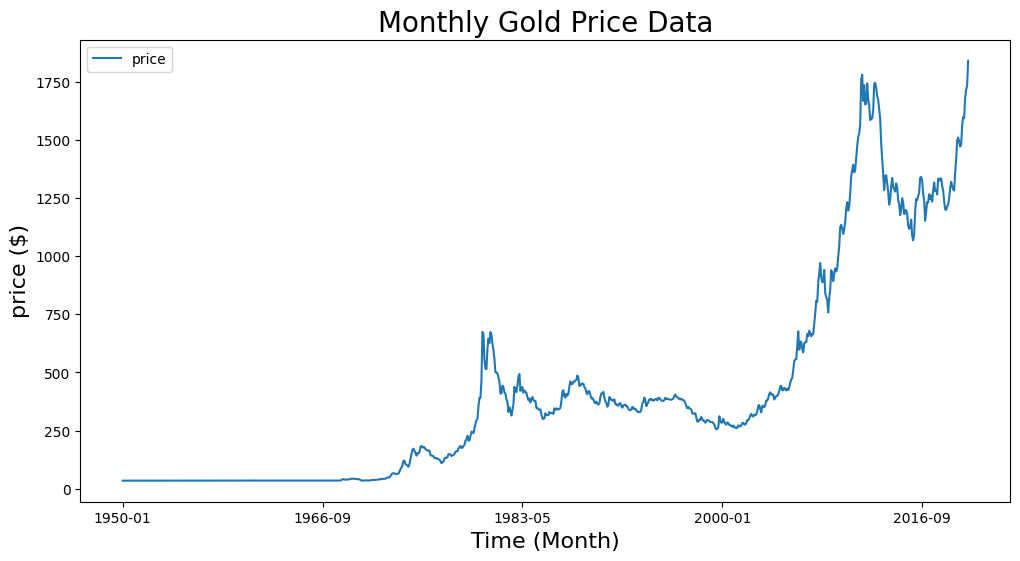

In [69]:
x = 'ds'
y = 'y'
Label = "price"
Figsize = (12,6)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'price ($)'
_fig_plot(df2,x,y)

모멘텀을 보자면, 전반적으로 플롯은 금 가격의 상승 추세를 보여주고 있다.

그러나 갑작스러운 급등 이후 금 가격은 하락했다.

또한 데이터에 존재하는 약간의 계절성을 볼 수 있지만 70년 간의 데이터를 플로팅했기 때문에 연간, 월별 또는 주별 계절성이 있는지 이해하기 어렵다.

**따라서 데이터의 일부를 가져와 확대해서 본다**

In [74]:
# df.tail(24)를 사용해서 지난 24개월 데이터만 가져오자
shortX = df2[['ds','y']].tail(24)
shortX = shortX.rename(columns={'ds' : 'dss', 'y':'yss'})
shortX.head()

,dss,yss
823,2018-08,1201.859
824,2018-09,1199.198
825,2018-10,1214.726
826,2018-11,1221.275
827,2018-12,1249.887


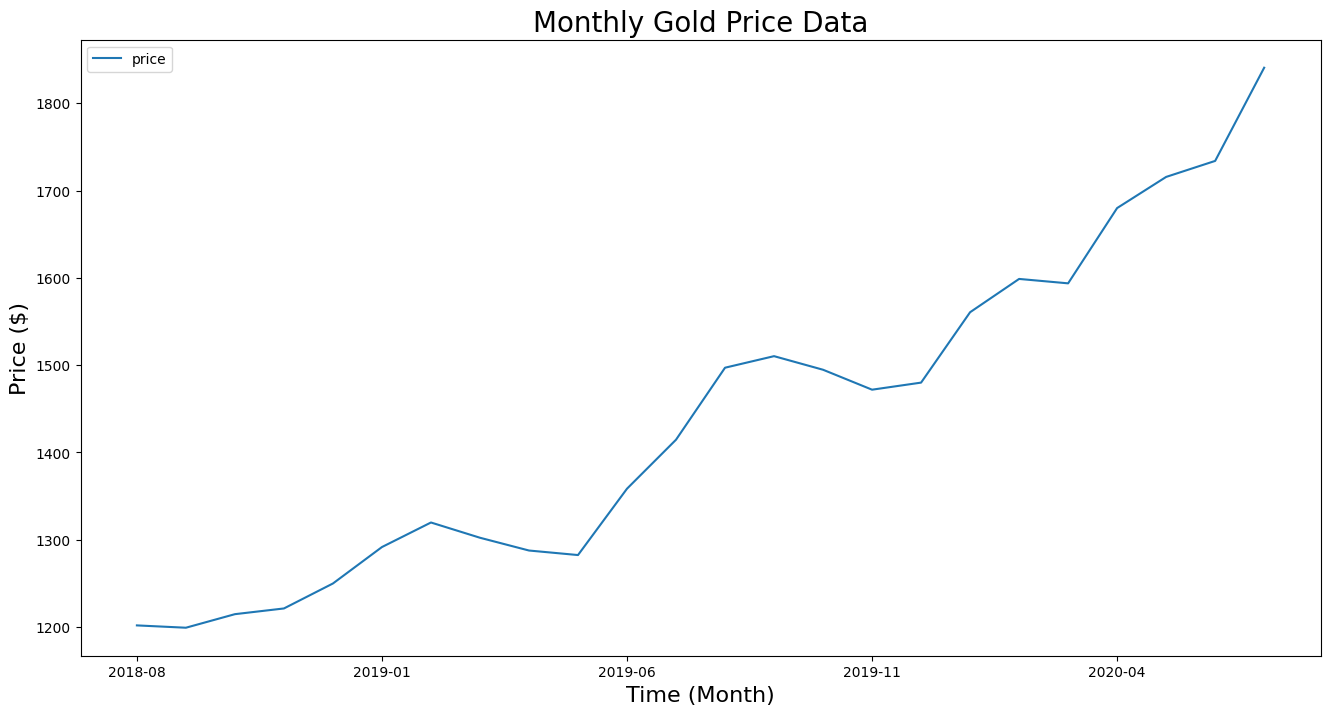

In [75]:
X = 'dss'
Y = 'yss'
Label = "price"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'Price ($)'
_fig_plot(shortX, X, Y)

이 플롯은 월별 계절성이 있지만, 계절성의 영향이 일정하지 않아보인다.

계절성의 지속적인 영향이 없는 이러한 종류의 시나리오에서는 additive seasonality 대신 Multiplicative seasonality를 사용하는 것이 좋다.

In [76]:
# train 데이터셋 만들기
train = df2.copy()

Available default hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None

In [77]:
prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality= 'auto',
                  growth='linear',
                  changepoints=None,
                  n_changepoints=25,
                  changepoint_range=0.8,
                  holidays=None,
                  seasonality_prior_scale=20,
#                  holidays_prior_scale=10,
                  changepoint_prior_scale=0.05,
                  mcmc_samples=0,
                  interval_width=0.8,
                  uncertainty_samples=1000,
                  stan_backend=None)
prophet.add_seasonality(name='yearly', period=365, fourier_order=15,
                      mode = 'multiplicative')
prophet.fit(train)


future = prophet.make_future_dataframe(periods=12, freq = 'MS')
forecast = prophet.predict(future)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/obvqz4bu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/a07wpap8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52419', 'data', 'file=/tmp/tmphlgk112i/obvqz4bu.json', 'init=/tmp/tmphlgk112i/a07wpap8.json', 'output', 'file=/tmp/tmphlgk112i/prophet_modelazl3azp0/prophet_model-20240405085531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] do

period = 12로 정의, 월간을 나타내는 MS로 frequency 정의

Printing outputs from Prophet prediction...
           ds       yhat  yhat_lower  yhat_upper
0 1950-01-01  77.040736  -66.743244  228.857668
1 1950-02-01  62.454272  -86.776821  200.539030
2 1950-03-01  35.844031 -114.276349  176.130237
3 1950-04-01  46.822866  -97.575342  199.531674
4 1950-05-01  24.236797 -127.987694  175.061814


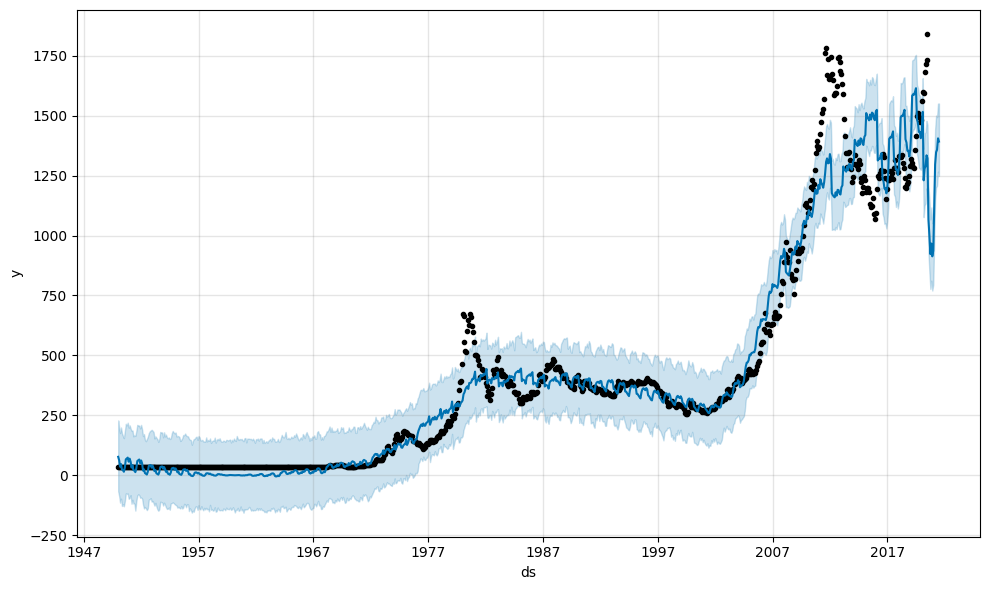

In [78]:
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
prophet.plot(forecast)
plt.show()

플롯설명 : 모델이 상승 및 하락 패턴을 포함한 과거 데이터에 대해 잘 맞는지를 표현해줌

In [79]:
# 모델 성능 평가를 위해 교차 검증 방법 수행
evaluation_model = cross_validation(prophet, initial = '4000 days', period = '360 days', horizon = '30 days')

INFO:prophet:Making 61 forecasts with cutoffs between 1961-03-13 00:00:00 and 2020-06-01 00:00:00


  0%|          | 0/61 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/lwb6wv9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/7jjbdeo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11421', 'data', 'file=/tmp/tmphlgk112i/lwb6wv9t.json', 'init=/tmp/tmphlgk112i/7jjbdeo9.json', 'output', 'file=/tmp/tmphlgk112i/prophet_modelvdxqlv31/prophet_model-20240405090057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/4onhxvir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphlgk112i/h3832e7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [82]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
3,6 days,2228.679917,47.208897,35.162197,0.106618,0.119499,0.107743,0.500000
12,17 days,2828.555428,53.184165,37.476269,0.102177,0.088948,0.106439,0.583333
11,16 days,3544.973572,59.539681,41.874094,0.100438,0.114501,0.103156,0.541667
17,22 days,6107.750592,78.152099,44.506288,0.137596,0.055704,0.146894,0.611111
16,21 days,8920.718168,94.449554,56.483233,0.149123,0.069237,0.154307,0.500000


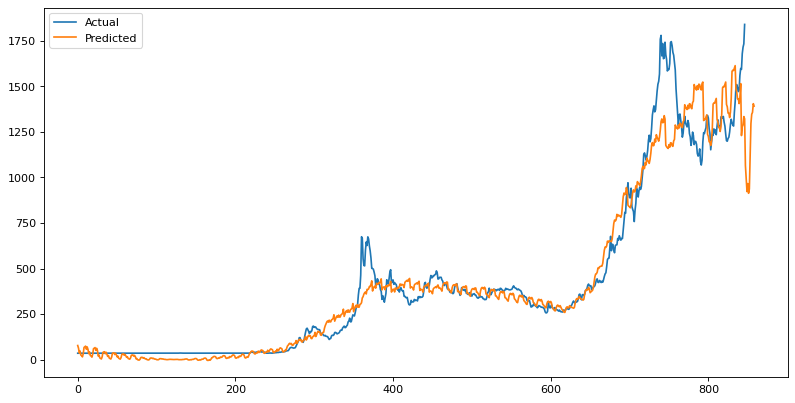

In [80]:
# 교차 검증 결과
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(12,6), dpi=80)

pltt.plot(train['y'].values, label = 'Actual')
pltt.plot(forecast['yhat'].values, label = 'Predicted')
pltt.legend()
pltt.show()

과거 데이터에 적당히 맞는다는 것을 보여주며, 미래에 대해서도 다음 달에 금 가격이 급격히 하락하는 것을 보여준다.